 ## test10.ipynb

Testing the various versions of the double sigma units, and networks that use them.

By `Sergio Verduzco`  
May, June 2018

In [1]:
%cd ..
from draculab import *
import numpy as np

/home/z/projects/draculab


### Test 0
Check the `port_idx` lists created after connecting double sigma units.

In [2]:
# Create two groups of 3 double sigma units 
net_params = {'min_delay' : 0.02, 'min_buff_size' : 8 } # parameter dictionary for the network
unit_params = {'type' : unit_types.double_sigma, 
               'init_val' : 0.5, 
               'n_ports' : 3,
               'slope' : 1.,
               'thresh' : 0.,
               'tau' : 0.01,
               'phi' : 0,
               'branch_params' : {
                   'branch_w' : [0.2, 0.3, 0.5],
                   'slopes' : 1.,
                   'threshs' : 0.
                                  }
              }
net = network(net_params)  # creating a newtwork
units1 = net.create(3,unit_params) # first group
units2 = net.create(3,unit_params) # second group

# connect the units
conn_spec = { 'rule' : 'all_to_all',
              'delay' : net_params['min_delay'],
              'allow_autapses' : True }
syn_spec = { 'type' : synapse_types.static,
             'init_w' : 1.0,
             'inp_ports' : [0, 1, 2]*3 } # the 3 units will project to ports 0, 1, 2
net.connect(units1, units2, conn_spec, syn_spec) 

syn_spec['inp_ports'] = [0, 2, 0]*3 # the 3 units project to ports 0, 2, 0
net.connect(units2, units1, conn_spec, syn_spec) # second unit projects to port 1

syn_spec['inp_ports'] = 0
net.connect([units1[0]], units1, conn_spec, syn_spec)

# Predicting these is a mind twister. You should have: 
# net.units1[0].port_idx = [ [0, 1, 2, 3], [], [] ]   -- remember these are indexes, not unit IDs
# net.units1[1].port_idx = [ [3], [], [0, 1, 2] ]
# net.units1[2].port_idx = [ [0, 1, 2, 3], [], []]
# net.units2[0].port_idx = [ [0, 1, 2], [], [] ]
# net.units2[1].port_idx = [ [], [0, 1, 2], [] ]
# net.units2[2].port_idx = [ [], [], [0, 1, 2] ]

units1_port_idx = ( [ [0, 1, 2, 3], [], [] ], [ [3], [], [0, 1, 2] ], [ [0, 1, 2, 3], [], [] ] )
units2_port_idx = ( [ [0, 1, 2], [], [] ], [ [], [0, 1, 2], [] ], [ [], [], [0, 1, 2] ] )


In [3]:
# compare with predicted values
for i in [0,1,2]:
    print(units1_port_idx[i] == net.units[units1[i]].port_idx)
    print(units2_port_idx[i] == net.units[units2[i]].port_idx)


True
True
True
True
True
True


### Test 1
Check the get_mp_input_sum function for `double_sigma` units

In [4]:
print(net.units[1].get_mp_inputs(0.))
print(net.units[1].get_mp_weights(0.))

[array([ 0.5]), array([], dtype=float64), array([ 0.5,  0.5,  0.5])]
[array([ 1.]), array([], dtype=float64), array([ 1.,  1.,  1.])]


In [5]:
# compare get_mp_inpt_sum against explicitly calculated values
f = lambda x: 1./(1. + np.exp(-x))
ohs = np.array([0.2,0.3,0.5])
for unit in range(6):
    inputs = net.units[unit].get_mp_inputs(0.)
    weights = net.units[unit].get_mp_weights(0.)
    ret1 = sum([ o*f(np.dot(w,i)) for o,w,i in zip(ohs, inputs, weights) ])
    ret2 = net.units[unit].get_mp_input_sum(0.)
    print(abs(ret1 - ret2) < 1e-5)

True
True
True
True
True
True


In [6]:
# In this cell you can compare the time of the two versions of get_mp_input_sum
%timeit [net.units[i].get_mp_input_sum(0.) for i in range(6)]
# Using version 1 (big zip): 78.7 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
# Using version 2 (accumulator): 83.8 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

88.2 µs ± 3.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Test 2
A single `double_sigma` unit implementing an AND constraint on its branches.  
__Proceed here directly after reset.__

In [1]:
# create the network using the ei_net tools
%cd ..
from ei_net import *

/home/z/projects/draculab


__Creating the input patterns__  
The input layer is simply 4 rows and 4 columns.
Each or the columns is an input to the corresponding branch. Your unit has 4 input branches, each with 4 synapses.
The idea is to have 5 presentations. On the i-th presentation the input will match the weight vectors of i-1 branches.
This gives an idea of the activation profile for the unit.
The input weight vector matrix is:

 $\begin{bmatrix} .5 & 0. & 0. & .5 \\
                  .5 & 0. & .5 & 0. \\
                  0. & .5 & 0. & .5 \\
                  0. & .5 & .5 & 0.
 \end{bmatrix}$
 
If the sum of the input vector's elements is 1, you'd expect an average inner product of 0.25, so using the uniform
branch weights [.25, .25, .25, .25] you can expect an average activation of $f(0.25)\approx.562$, whereas the maximum activation is around .622.
Setting the threshold around .3 should do the trick.

The 5 input patterns are:

$\begin{bmatrix} .25 & .25 & .25 & .25 \\
                 .25 & .25 & .25 & .25 \\
                 .25 & .25 & .25 & .25 \\
                 .25 & .25 & .25 & .25 \end{bmatrix}$
$\begin{bmatrix} .5 & .25 & .25 & .25 \\
                 .5 & .25 & .25 & .25 \\
                 0. & .25 & .25 & .25 \\
                 0. & .25 & .25 & .25 \end{bmatrix}$
$\begin{bmatrix} .5 & 0. & .25 & .25 \\
                 .5 & 0. & .25 & .25 \\
                 0. & .5 & .25 & .25 \\
                 0. & .5 & .25 & .25 \end{bmatrix}$
$\begin{bmatrix}  .5 & 0. & 0. & .25 \\
                  .5 & 0. & .5 & .25 \\
                  0. & .5 & 0. & .25 \\
                  0. & .5 & .5 & .25 \end{bmatrix}$
$\begin{bmatrix} .5 & 0. & 0. & .5 \\
                  .5 & 0. & .5 & 0. \\
                  0. & .5 & 0. & .5 \\
                  0. & .5 & .5 & 0. \end{bmatrix}$

where each column corresponds to the input to one branch. The input pattern function (`inp_pat`) will return one of those matrices strecthed as a vector, going column by column. This format is because I wrote this before I had `mr_run` and its associated methods.

In [2]:
# Creating input pattern function
## all the input pattern are in this nested list
all_inps = [ [ .25]*16,
            [.5, .5, 0., 0.]+([.25]*12),
            [.5, .5, 0., 0.]+[0., 0., .5, .5]+([.25]*8),
            [.5, .5, 0., 0.]+[0., 0., .5, .5]+[0., .5, 0., .5]+([.25]*4),
            [.5, .5, 0., 0.]+[0., 0., .5, .5]+[0., .5, 0., .5]+[.5, 0., .5, 0.]
          ]
def inp_pat(pres, rows, cols):
    return all_inps[pres%5]

In [3]:
# Create the ei_net object
xnet = ei_net()

In [4]:
# Set its parameters
## geometry
xnet.set_param('e_geom', 'rows', 1)
xnet.set_param('e_geom', 'columns', 1)
xnet.set_param('i_geom', 'rows', 0)
xnet.set_param('i_geom', 'colums', 0)
xnet.set_param('x_geom', 'rows', 4)
xnet.set_param('x_geom', 'columns', 4)
xnet.set_param('n', 'w_track', 1)

## double sigma unit parameters
xnet.set_param('e_pars', 'type', unit_types.double_sigma)
xnet.set_param('e_pars', 'slope_min', 5.)
xnet.set_param('e_pars', 'slope_wid', 0.)
xnet.set_param('e_pars', 'thresh_min', .8)
xnet.set_param('e_pars', 'thresh_wid', 0.)
xnet.set_param('e_pars', 'phi', 0)
xnet.set_param('e_pars', 'n_ports', 4)
xnet.set_param('e_pars', 'branch_params', {'branch_w' : [0.25]*4, 'slopes' : 4, 'threshs' : 0.4})

## connection parameters
xnet.set_param('ee_conn', 'allow_autapses', False)
xnet.set_param('xe_conn', 'connection_type', 'divergent')
xnet.set_param('xe_conn', 'mask', {'circular' : {'radius' : 10}})
xnet.set_param('xe_conn', 'kernel', 1.)
del xnet.xe_conn['weights'] # so I can set weights with 'init_w'
#xnet.set_param('xe_syn', 'init_w',    [.5, .5, 0., 0.]+[0., 0., .5, .5]+[0., .5, 0., .5]+[.5, 0., .5, 0.])
xnet.set_param('xe_syn', 'init_w',    [1., 1., 0., 0.]+[0., 0., 1., 1.]+[0., 1., 0., 1.]+[1., 0., 1., 0.])
xnet.set_param('xe_syn', 'inp_ports', [ 0,  0,  0, 0,]+[ 1,  1,  1,  1]+[ 2,  2,  2,  2]+[ 3,  3,  3,  3])

## build the network
xnet.build()

/home/z/projects/draculab/topology.py:410: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)
/home/z/projects/draculab/topology.py:279: UserWarning: topo_connect received an empty list as an argument
  warn('topo_connect received an empty list as an argument', UserWarning)


In [5]:
# Simulate
n_pres = 5
pres_time = 1.
xnet.run(n_pres, pres_time, inp_pat)

Presentation 0 took 0.10403561592102051 seconds.
Presentation 1 took 0.10877442359924316 seconds.
Presentation 2 took 0.11679983139038086 seconds.
Presentation 3 took 0.10609817504882812 seconds.
Presentation 4 took 0.11506366729736328 seconds.
Total execution time is 0.551804780960083 seconds


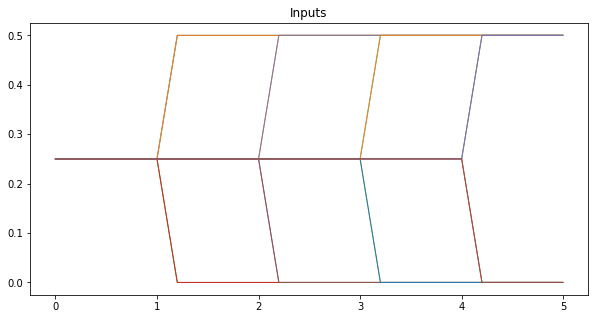

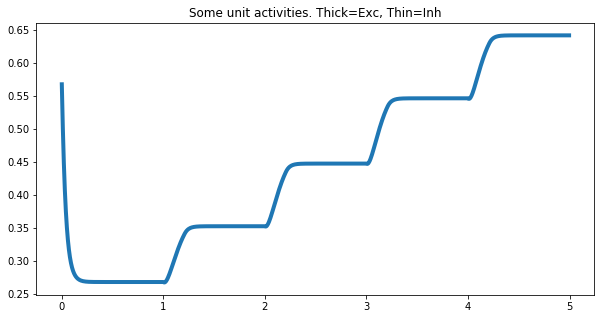

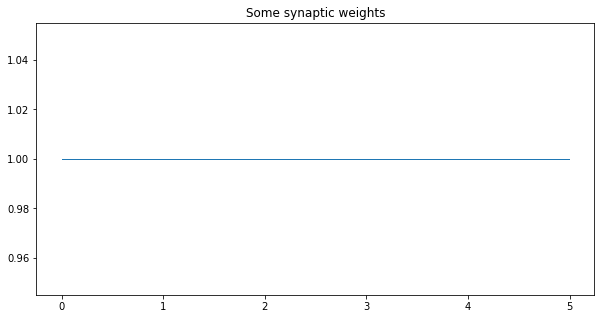

In [6]:
xnet.basic_plot()

In [7]:
# Compare the output of the cell at each presentation with explicitly calculated values
## calculate the value at each presentation
f = lambda x, sl, th : 1./(1. + np.exp(-sl*(x - th)))
calc_vals = []
slope = xnet.e_pars['slope_min']
thresh = xnet.e_pars['thresh_min']
sl = xnet.e_pars['branch_params']['slopes']
th = xnet.e_pars['branch_params']['threshs']
for i in range(5):
    inp = 0.25*( (0.5*0.25*2)*(4-i) + (0.5*0.5*2)*i )
    calc_vals.append(f( f(inp, sl, th), slope, thresh))

## extract the values from the simulation and compare with explicit values
for i in range(5):
    sim_val = xnet.all_activs[xnet.e[0]][200*(i+1) - 1] # min_delay=.005 => 200 data points per second
    print( calc_vals[i] - sim_val < 1e-4 )

True
True
True
True
True


### Test 3
Reproduce the ei_net results with double_sigma units (obtained with ei_runner in January)  
__Proceed here directly after reset.__

We will use double_sigma units with two branches, one for layer inputs (port 0), and one for external inputs (port 1).

In [1]:
# create the network using the ei_net tools
%cd ..
from ei_net import *

/home/z/projects/draculab


In [2]:
# Creating input patterns
n_pat = 4  # number of input patterns
pat_arr = np.zeros((4, 25)) # ei_runner.n['x'])) # array with all input patterns

for row in range(5):
    for col in range(5):
        idx = 5*col + row
        if row == col or row+col == 4: # The X input pattern
            pat_arr[0,idx] = 1
        if row == 2 or col == 2:  # The + input pattern
            pat_arr[1,idx] = 1
        if row == 1 or row == 3:  # The = input pattern
            pat_arr[2,idx] = 1
        if col == 1 or col == 3:  # The || input pattern
            pat_arr[3,idx] = 1
pat_arr = pat_arr / 5.

def inp_pat(pres, rows, columns, random=True):
    # The function that creates the input pattern shown at each presentation in ei_net.run
    if random:
        idx = np.random.randint(4)
    else:
        idx = pres % 4
    return pat_arr[idx, :]
#for i in range(6):
#    print(np.reshape(inp_pat(5, 4, 2),(5,5)))

In [3]:
# Setting parameters
ei_runner = ei_net()
#----------------------------------
## double sigma unit parameters
ei_runner.set_param('e_pars', 'type', unit_types.double_sigma)
ei_runner.set_param('e_pars', 'slope_min', 5.)
ei_runner.set_param('e_pars', 'slope_wid', .1)
ei_runner.set_param('e_pars', 'thresh_min', .2)
ei_runner.set_param('e_pars', 'thresh_wid', 0.1)
ei_runner.set_param('e_pars', 'n_ports', 2)
ei_runner.set_param('e_pars', 'branch_params', {'branch_w' : [0.5, 0.5], 'slopes' : 4, 'threshs' : 0.1})
#----------------------------------
ei_runner.annotate("Adjusting size of e,i groups.")
ei_runner.set_param('e_geom', 'rows', 12)
ei_runner.set_param('e_geom', 'columns', 12)
ei_runner.set_param('i_geom', 'rows', 6)
ei_runner.set_param('i_geom', 'columns', 6)
ei_runner.annotate("Compensating for the ratio of excitatory to inhibitory units.")
ei_runner.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
ei_runner.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
ei_runner.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.5, 'high' : -0.01}})
ei_runner.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
#----------------------------------
ei_runner.annotate("Setting input parameters")
ei_runner.set_param('x_geom', 'rows', 5) 
ei_runner.set_param('x_geom', 'columns', 5) 
ei_runner.set_param('xe_conn', 'weights', {'uniform' : {'low': 0.05, 'high' : 4.}})
ei_runner.set_param('xe_syn', 'inp_ports', 1)
ei_runner.set_param('xi_conn', 'weights', {'uniform' : {'low': 0.05, 'high' : 4.}})
ei_runner.set_param('xe_conn', 'mask', {'circular': {'radius': .3}})
ei_runner.set_param('xi_conn', 'mask', {'circular': {'radius': .3}})
ei_runner.set_param('xi_syn', 'inp_ports', 1)
#----------------------------------
ei_runner.annotate("Using Oja input synapses")
ei_runner.set_param('xe_syn', 'type', synapse_types.oja)
ei_runner.set_param('xe_syn', 'lrate', 1./50.)
ei_runner.set_param('xi_syn', 'type', synapse_types.oja)
ei_runner.set_param('xi_syn', 'lrate', 1./50.)
#----------------------------------
ei_runner.annotate("Using BCM EE synapses")
ei_runner.set_param('ee_syn', 'type', synapse_types.bcm)
ei_runner.set_param('ee_syn', 'lrate', 1./50.)
#ei_runner.set_param('ee_syn', 'omega', 2.)
#----------------------------------
ei_runner.annotate("Using corr_homeo_inhib IE synapses")
ei_runner.set_param('ie_syn', 'type', synapse_types.corr_inh)
ei_runner.set_param('ie_syn', 'lrate', 1./40.)
ei_runner.set_param('e_pars', 'des_act', 0.4)
#----------------------------------
ei_runner.annotate("Using anti_cov_pre EI synapses")
ei_runner.set_param('ei_syn', 'type', synapse_types.anticov_pre)
ei_runner.set_param('ei_syn', 'lrate', .02)
#----------------------------------
"""
ei_runner.annotate('Using exp_rate_dist ee synapses.')
ei_runner.set_param('ee_syn', 'type', synapse_types.exp_rate_dist)
ei_runner.set_param('ee_syn', 'lrate', 1.)
ei_runner.set_param('ee_syn', 'wshift', 10.)
ei_runner.set_param('ee_syn', 'c', 2.)
"""
#----------------------------------
"""
ei_runner.annotate("Using exp_dist_sig units for the excitatory population.")
ei_runner.set_param('e_pars', 'type', unit_types.exp_dist_sig)
ei_runner.set_param('e_pars', 'tau_scale', 0.1)
ei_runner.set_param('e_pars', 'c', 3.)
ei_runner.set_param('e_pars', 'Kp', .1)

ei_runner.annotate("Using exp_dist_sig units for the inhibitory population.")
ei_runner.set_param('i_pars', 'type', unit_types.exp_dist_sig)
ei_runner.set_param('i_pars', 'tau_scale', 0.1)
ei_runner.set_param('i_pars', 'c', 3.)
ei_runner.set_param('i_pars', 'Kp', .1)
"""
#----------------------------------
"""
ei_runner.annotate("Using exp_dist_sig_thr units for the excitatory population.")
ei_runner.set_param('e_pars', 'type', unit_types.exp_dist_sig_thr)
ei_runner.set_param('e_pars', 'tau_thr', 0.005)
ei_runner.set_param('e_pars', 'c', 3.)

ei_runner.annotate("Using exp_dist_sig_thr units for the inhibitory population.")
ei_runner.set_param('i_pars', 'type', unit_types.exp_dist_sig_thr)
ei_runner.set_param('i_pars', 'tau_thr', 0.001)
ei_runner.set_param('i_pars', 'c', 3.)
"""
#----------------------------------
ei_runner.set_param('n', 'w_track', 16)
#----------------------------------
ei_runner.build()

In [19]:
# Simulating
n_pres = 10
pres_time = 1.
ei_runner.mr_run(n_pres, pres_time, set_mr_inp_pat=inp_pat)

Presentation 0 took 21.038350582122803 seconds.
Presentation 1 took 20.464970588684082 seconds.
Presentation 2 took 20.219773054122925 seconds.
Presentation 3 took 20.182456016540527 seconds.
Presentation 4 took 20.08332657814026 seconds.
Presentation 5 took 20.245805025100708 seconds.
Presentation 6 took 20.00130605697632 seconds.
Presentation 7 took 20.171642780303955 seconds.
Presentation 8 took 20.16066551208496 seconds.
Presentation 9 took 20.222943782806396 seconds.
Total execution time is 202.7943994998932 seconds


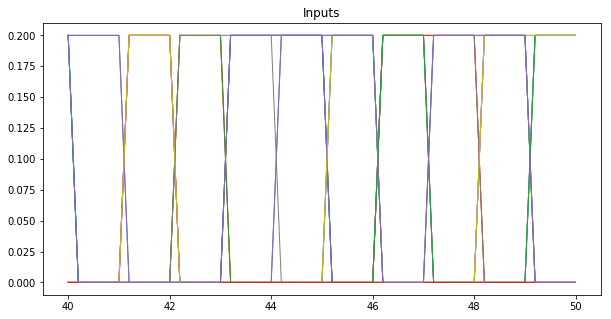

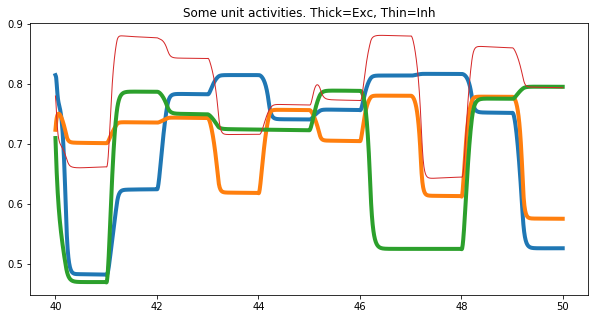

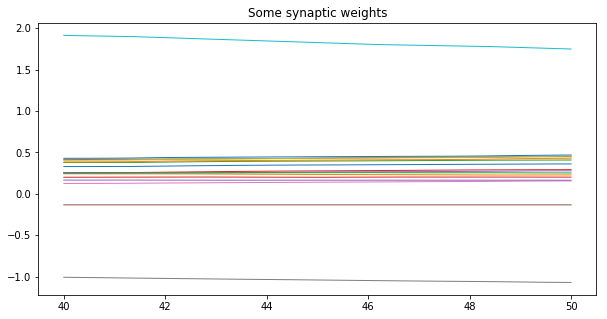

In [20]:
%matplotlib inline
ei_runner.basic_plot()

In [21]:
ei_runner.double_anim(ei_runner.e, slider=False, interv=20, nbins=20, thr=0.5, pdf=True)

[ 28  95 139  99 115]


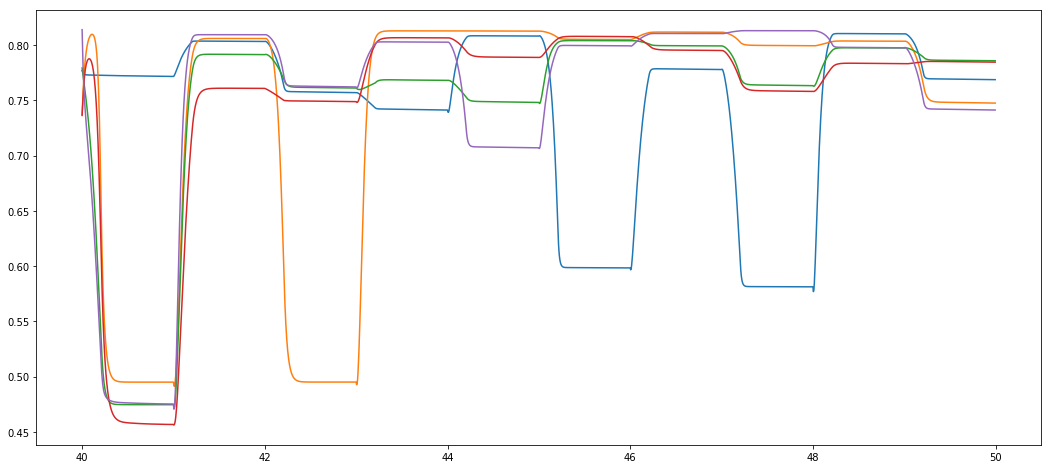

In [22]:
# Plot the highest excitatory unit activities
%matplotlib inline
n_top = 5  # how many units to plot
top_pop = np.array(ei_runner.e)  # population to visualize
top_units = ei_runner.all_activs[top_pop].sum(1).argpartition(-n_top)[-n_top:]
print(top_units)
top_act_fig = plt.figure(figsize=(18,8))
top_acts = ei_runner.all_activs[top_pop[top_units]].transpose()
plt.plot(ei_runner.all_times, top_acts)
plt.show()

[  5  72  33  16  25  51  26 114  36]


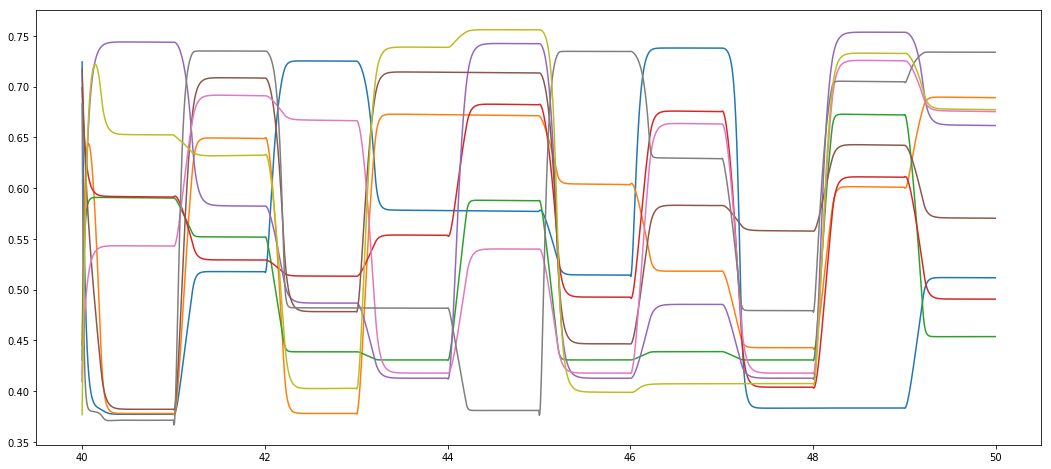

In [23]:
# Plot the lowest excitatory unit activities
n_bottom = 10  # how many units to plot
bottom_pop = np.array(ei_runner.e)  # population to visualize
bottom_units = ei_runner.all_activs[bottom_pop].sum(1).argpartition(n_bottom)[0:n_bottom-1]
print(bottom_units)
bottom_act_fig = plt.figure(figsize=(18,8))
bottom_acts = ei_runner.all_activs[bottom_pop[bottom_units]].transpose()
plt.plot(ei_runner.all_times, bottom_acts)
plt.show()

In [18]:
# Look at the connections
ei_runner.conn_anim(ei_runner.x, ei_runner.e, interv=80, slider=True, weights=True)

interactive(children=(IntSlider(value=72, description='frame', max=144, min=1), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>